In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist


#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
import figurefirst

#misc
import time
np.set_printoptions(suppress=True)

## Visualization

### Heatmap Calculation

In [47]:
df = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/LowRes/Data_expected.h5')
# df = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run01/Run01_expected.h5')

In [48]:
query_1 = 'odor>=2'
df_occurence = df.query(query_1)

In [49]:
# df_occurence.insert(26,"slope",(df_occurence.nearest_from_streakline/df_occurence.distance_from_source))
df_occurence.insert(26,"slope",(df_occurence.nearest_from_streakline/df_occurence.distance_from_source))
query_2 = 'slope>=0.5'
df_odor_opposite =df_occurence.query(query_2)

In [62]:
x = np.linspace(0,45,45)
y = np.linspace(0,35,35)
H1, x, y = np.histogram2d(df_occurence.distance_from_source, df_occurence.nearest_from_streakline, bins=(x, y), 
                          weights = df_occurence.odor)
N_Encounter = H1.T 
H2, x, y = np.histogram2d(df.distance_from_source, df.nearest_from_streakline, bins=(x, y), 
                          weights = df.odor)
Total = H2.T 

# Encounters = np.array(H1)/np.array(H2)
# Encountzers[Encounters == np.inf] = 0

## removing areas less than 4000 deno

for i in range (len(Total)):
    for j in range(len(Total[i])):
        if Total[i][j]<200:
            Total[i][j] =0
            N_Encounter[i][j]=0

Encounters = np.array(N_Encounter)/np.array(Total)
Encounters[Encounters == np.inf] = 0

<ipython-input-62-4819a457941d>:21: RuntimeWarning: invalid value encountered in true_divide
  Encounters = np.array(N_Encounter)/np.array(Total)


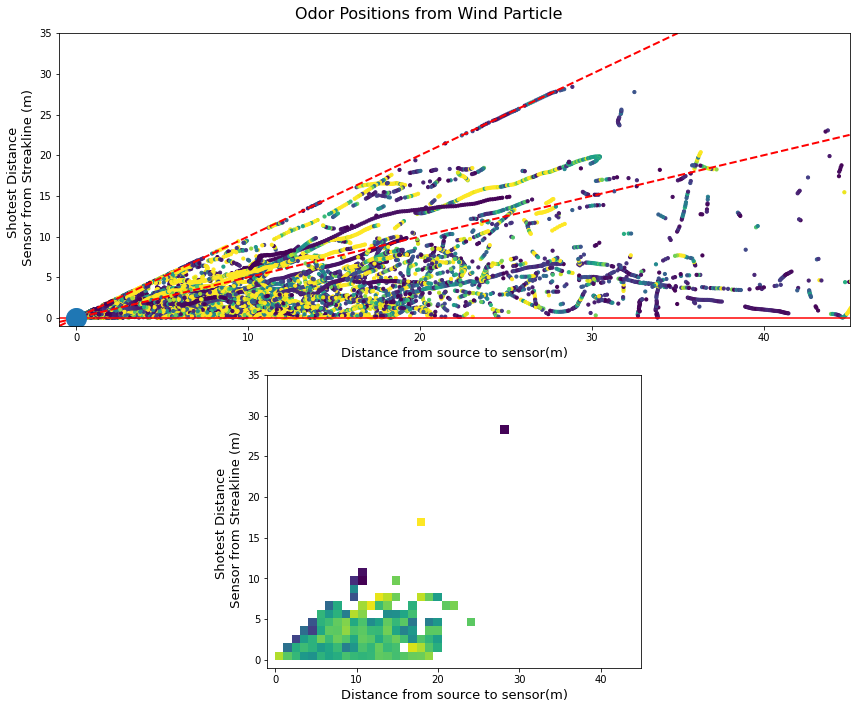

In [65]:
f, (ax1,ax2) = plt.subplots(2,1, figsize =(12,10) , gridspec_kw={'height_ratios': [4,4]})

#plot wind vs odor from source and each other
f.suptitle('Odor Positions from Wind Particle', fontsize = 16)
# ax1 = plt.axes(xlim =(0,35), ylim=(-5,28))
ax1.axline((0, 0), slope=1.0, linestyle='dashed', linewidth=2, color='r')
ax1.axline((0, 0), slope=0.5, linestyle='dashed', linewidth=2, color='r')
ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
# var = ax1.scatter(df_occurence.distance_from_source, df_occurence.nearest_particle, cmap = 'viridis', 
#                   c = df_occurence.odor,  s = 10)
var = ax1.scatter(df_occurence.distance_from_source, df_occurence.nearest_from_streakline, cmap = 'viridis', 
                  c = df_occurence.odor,  s = 10)
# ax1.set_xlabel('Distance along Streakline(m)' , fontsize = 13)
ax1.set_xlabel('Distance from source to sensor(m)' , fontsize = 13)
ax1.set_ylabel('Shotest Distance \n Sensor from Streakline (m)' , fontsize = 13)
ax1.set_xlim ([-1,45])
ax1.set_ylim([-1,35])


# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# f.colorbar(var, cax=cax, orientation = 'vertical')

# x = np.linspace(0,25,11)
# y = np.linspace(0,10,25)
# ax2.set_xlabel('Distance along Streakline(m)', fontsize = 13)
ax2.set_xlabel('Distance from source to sensor(m)' , fontsize = 13)
ax2.set_ylabel('Shotest Distance \n Sensor from Streakline (m)', fontsize = 13)
var2 = ax2.imshow(Encounters, interpolation='nearest', origin='lower',cmap = 'viridis', extent=[x[0], x[-1], y[0], y[-1]])
start, end = ax2.get_xlim()
# var = ax2.scatter(df_odor_opposite.distance_from_source, df_odor_opposite.nearest_from_streakline, cmap = 'viridis', 
#                   c = df_odor_opposite.odor,  s = 10)
# ax1.set_xlabel('Distance along Streakline(m)' , fontsize = 13)
# ax2.set_xlabel('Distance from source to sensor(m)' , fontsize = 13)
# ax2.set_ylabel('Shotest Distance \n Sensor from Streakline (m)' , fontsize = 13)
ax2.set_xlim ([-1,45])
ax2.set_ylim([-1,35])



# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# f.colorbar(var2, cax=cax, orientation = 'vertical')

f.tight_layout()
f.savefig('../../heatmap01encounter.jpeg')

In [70]:
dfstats.keys()

Index(['avg_dist_along_streakline', 'avg_dist_from_source',
       'avg_dist_from_streakline', 'avg_relative_motion', 'odor',
       'length_of_encounter', 'odor_intermittency', 'odor_stdev',
       'tri_pressure', 'tri_temperature', 'linear_acc_x', 'linear_acc_y',
       'linear_acc_z', 'imu_angular_x', 'imu_angular_y', 'imu_angular_z',
       'master_time'],
      dtype='object')

In [85]:
x = np.linspace(0,45,45)
y = np.linspace(0,35,35)
H1, x, y = np.histogram2d(dfstats.avg_dist_from_source, dfstats.avg_dist_from_streakline, bins=(x, y), 
                          weights = dfstats.length_of_encounter)
Encounter = H1.T 

In [86]:
H2, x, y = np.histogram2d(dfstats.avg_dist_from_source, dfstats.avg_dist_from_streakline, bins=(x, y), 
                          weights = dfstats.odor_intermittency)
Intermittency = H2.T 

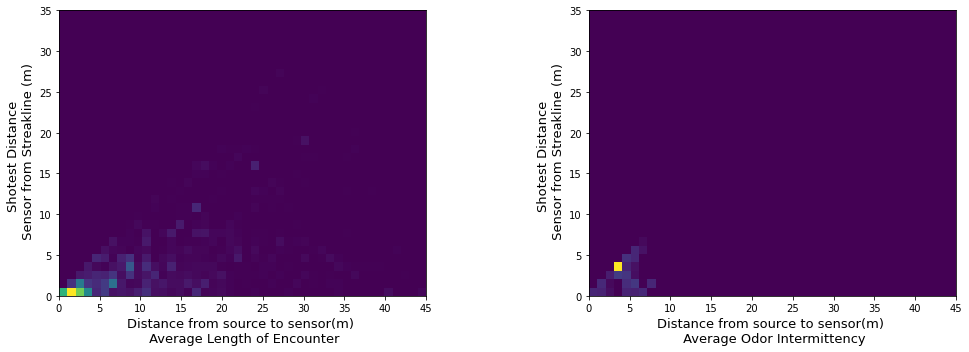

In [94]:
f, (ax1,ax2) = plt.subplots(1,2, figsize =(15,5) , gridspec_kw={'width_ratios': [1,1]})
# ax1 = plt.axes (xlim=(0,45), ylim=(0,35))

# f.suptitle('Heatmap-Length of Encounter', fontsize = 16)
ax1.set_xlabel('Distance from source to sensor(m) \n Average Length of Encounter' , fontsize = 13)
ax1.set_ylabel('Shotest Distance \n Sensor from Streakline (m)', fontsize = 13)
ax1.imshow(Encounter, interpolation='nearest', origin='lower',cmap = 'viridis', extent=[x[0], x[-1], y[0], y[-1]])

ax2.set_xlabel('Distance from source to sensor(m) \n Average Odor Intermittency' , fontsize = 13)
ax2.set_ylabel('Shotest Distance \n Sensor from Streakline (m)', fontsize = 13)
ax2.imshow(Intermittency, interpolation='nearest', origin='lower',cmap = 'viridis', extent=[x[0], x[-1], y[0], y[-1]])


f.tight_layout()
f.savefig('../../heatmap02stats.jpeg')
# plt.close()

#### Find if there was direction change back in time for the above extracted points

In [53]:
angle_changes = []
# 100 rows approx 10 seconds for low res
# 2002 rows approx 10 seconds for hi res
lookback_time = 100 * 5
for i in range(0,len(df_odor_opposite.index)):
    angle = np.abs(df.D[(df_odor_opposite.index[i]-lookback_time):df_odor_opposite.index[i]] - df.D[df_odor_opposite.index[i]])
    if (angle>90).any() == True: angle_changes.append(1)
    else: angle_changes.append(0)

In [105]:
angle_changes_1 = []
# 100 rows approx 10 seconds for low res
# 2002 rows approx 10 seconds for hi res
lookback_time = 100 * 5
for i in range(0,len(df2.index)):
    angle = np.abs(df.D[(df2.index[i]-lookback_time):df2.index[i]] - df.D[df2.index[i]])
    if (angle>90).any() == True: angle_changes_1.append(1)
    else: angle_changes_1.append(0)

In [106]:
angle_changes_1.count(1)/(angle_changes_1.count(0)+angle_changes_1.count(1))

0.23260547174635643

In [157]:
# df_odor_opposite=df_odor_opposite.drop(['angle_greater_90'],axis=1)
# df_odor_opposite.insert(10,"angle_greater_90",angle_changes)
# df_odor_opposite['angle_greater_90'].value_counts()  

In [54]:
angle_changes.count(1)/(angle_changes.count(0)+angle_changes.count(1))

0.5273328248156623

In [59]:
dfstats = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/LowRes/DataCalculatedStats_1.h5')
# df = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run01/Run01_expected.h5')

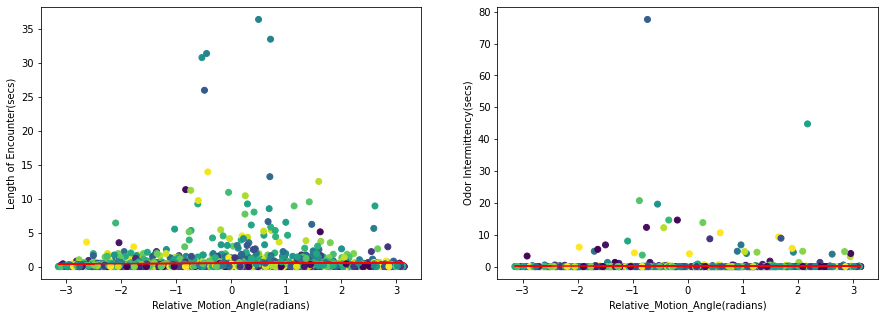

In [55]:
f, (ax1,ax2) = plt.subplots(1,2, figsize =(15,5) , gridspec_kw={'width_ratios': [1,1]})

ax1.scatter(dfstats.avg_relative_motion, dfstats.length_of_encounter,  c=dfstats.odor)
# plt.plot(df.avg_relative_motion, df.length_of_encounter, 'o')
ax1.set_ylabel('Length of Encounter(secs)')
ax1.set_xlabel('Relative_Motion_Angle(radians)')
m, b = np.polyfit(dfstats.avg_relative_motion, dfstats.length_of_encounter, 1)
ax1.plot(dfstats.avg_relative_motion, m*dfstats.avg_relative_motion + b , c='r')

ax2.scatter(dfstats.avg_relative_motion, dfstats.odor_intermittency, c=dfstats.odor)
ax2.set_ylabel('Odor Intermittency(secs)')
ax2.set_xlabel('Relative_Motion_Angle(radians)')
m1, b1 = np.polyfit(dfstats.avg_relative_motion, dfstats.odor_intermittency, 1)
ax2.plot(dfstats.avg_relative_motion, m1*dfstats.avg_relative_motion + b1 , c='r')

f.savefig('../../relative_motion.jpeg')

In [97]:
df2 = df[~df.isin(df_odor_opposite)].dropna()

97775

### Time Series Plot

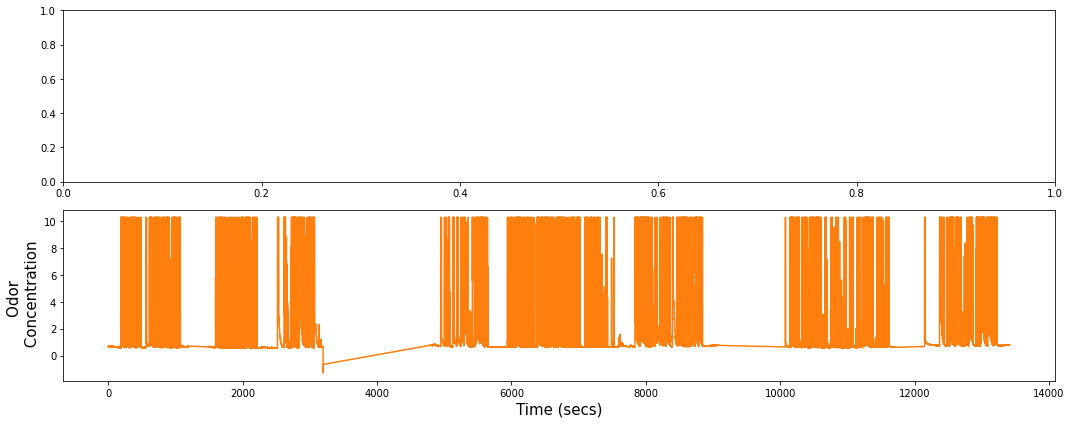

In [69]:
f, (ax1,ax2) = plt.subplots(2, 1,figsize=(15,6))
# ax1.set_prop_cycle('color',[plt.cm.OrRd(i) for i in df.odor])

# ax1.set_facecolor('black')
# ax1.plot(df.sync_time, df.odor, color='Purple')
# ax1.set_ylabel('Odor \n Concentration', fontsize=15)
# ax1.title.set_text('Encountered Particle')
# ax2.plot(df.sync_time,df.odor, color='C1')
# ax2.set_xlabel('Time (secs)', fontsize=15)
# ax2.set_ylabel('Odor \n Concentration', fontsize=15)
# ax2.title.set_text('Calculated Particle')

# f.suptitle('Radius**0.5*.01', fontsize =20)
f.tight_layout()
# # f.savefig(dir_save+'Run0'+str(run)+'_encounteredVsExpected.jpeg')

### Summary Plot

In [3]:
# f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize =(15,15) , gridspec_kw={'height_ratios': [8,3,3,3]})

# #plot wind vs odor from source and each other
# f.suptitle('Odor Positions from Wind Particle', fontsize = 16)
# # ax1 = plt.axes(xlim =(0,35), ylim=(-5,28))
# ax1.axhline(0, color = 'red')
# ax1.plot(0,0,'o', markersize = 20)
# # area = df.radius**2*0.4*m.pi #area
# # ax1.scatter(area[0:30]**2,df.mock[0:30])
# # ax1.scatter(df.sync_time[::300], df.mock[::300],  facecolors='none', edgecolors='b', s = area[::300])
# var = ax1.scatter(df.distance_along_streakline, df.nearest_particle, cmap = 'BuPu', c = df.odor,  s = 10)
# ax1.set_xlabel('Distance - Sensor to Source (meters)' , fontsize = 15)
# ax1.set_ylabel('Distance - Sensor to Streakline (meter)' , fontsize = 15)
# # ax1.xaxis.set_ticks(np.linspace(0, 30, 31).astype(int))
# # ax1.yaxis.set_ticks(np.linspace(0, 35, 10).astype(int))
# ax1.grid()

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('top', size='5%', pad=0.05)
# f.colorbar(var, cax=cax, orientation = 'horizontal')

# #plot concentration
# ax2.plot(df.sync_time,df.odor,color='Purple' , label="Encountered Odor")
# ax2.fill_between(df.sync_time, df.odor.min(), 11, where=df.odor_expected>0 ,facecolor='C1', alpha=1, label="Expected Odor")
# # ax2.plot(df.sync_time, df.odor_expected, label="Expected Odor")
# ax2.set_xlabel('Time (seconds)' , fontsize = 15)
# ax2.set_ylabel('Odor \n Comparison' , fontsize = 15)
# # ax2.set_facecolor('black')

# lgd=ax2.legend(loc='upper right',fancybox=True, shadow=True)

# ## plot direction
# ax3.plot(df.sync_time,df.D, color = 'green', label="Wind Direction")
# # ax3.plot(df.sync_time,sensor_direction, color = 'purple', label="Sensor Direction")
# ax3.set_xlabel('Time (seconds)' , fontsize = 15)
# ax3.set_ylabel('Direction (degrees)' , fontsize = 15)
# # ax3.axhline(150, color = 'red')
# lgd=ax3.legend(loc='upper right',fancybox=True, shadow=True)



# ## plot speed
# ax4.plot(df.sync_time,df.S2, color = 'green', label="Wind Speed")
# ax4.set_xlabel('Time (seconds)' , fontsize = 15)
# ax4.set_ylabel('Wind Speed (m/s)' , fontsize = 15)
# lgd=ax4.legend(loc='upper right',fancybox=True, shadow=True)
# # ax4.axhline(1.0, color = 'red')

# f.tight_layout()

# # f.savefig(dir_save+'Run0'+str(run)+'_plot_summary.jpeg')